In [45]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder, 
    OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    ShuffleSplit,
    learning_curve,
    GridSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt

from scipy.stats import f_oneway

from joblib import dump, load

In [2]:
credit_df = pd.read_parquet(r"../data/types_fixed_german_credit_data.parquet", engine="pyarrow")
credit_features = credit_df.drop_duplicates(subset=["Unnamed: 0"])

In [3]:
selected_features = ['Credit amount', 'Purpose', 'Job', 'Sex', 'Saving accounts', 'Housing', 'Risk', 'Age']
credit_features = credit_features[selected_features]

I don't select the credit duration due to its correlation with credit amount.

In [4]:
credit_features = credit_features.dropna(subset=["Risk"])
credit_features["Risk"] = credit_features["Risk"].map({"good": 1, "bad" : 0})

In [5]:
num_cols = ["Credit amount", "Age"]
cat_cols = ["Purpose", "Housing", "Sex"]
cat_ord_cols = ["Saving accounts", "Job"]

In [6]:
def get_features_names(_, feature_names) -> np.ndarray:
    return feature_names

def clean_features(X: pd.DataFrame, values: dict[str] = None, expected: bool = True):
    assert isinstance(X, pd.DataFrame)
    assert isinstance(values, dict) or values is None 
    
    values = {
        "Housing": ["own", "rent", "free"],
        "Sex" : ["male", "female"],
        "Purpose" : [
            "car", 
            "radio/TV", 
            "furniture/equipment", 
            "business",
            "education",
            "repairs",
            "domestic appliances",
            "vacation/others"
        ]
    } if not values and expected else values
    
    categories_to_review: list[str] = list(set(X.columns).intersection(set(values.keys())))
    if len(categories_to_review) == 0: return X
    
    X[categories_to_review] = X[categories_to_review].apply(
        lambda x: x.where(x.isin(values[x.name]))
    ) if expected else X[categories_to_review].apply(
        lambda x: x.where(~x.isin(values[x.name]))
    )
    return X
    
    
def remove_outliers(X: pd.DataFrame, threshold: float = 1.5) -> pd.DataFrame:
    """
    Replace outliers from numeric columns given a certain treshold with NAN.
    Args:
        threshold (float, optional): Treshold for removing minor (1.5) or extreme outliers (3.0). Defaults to 1.5.
    """
    assert isinstance(X, pd.DataFrame)
    assert 1.5 <= threshold <= 3.0
    Q1, Q3 = X.quantile(0.25), X.quantile(0.75)
    IQR: float = Q3 - Q1
    mask: function = ~((X >= (Q1 - threshold * IQR)) & (X <= (Q3 + threshold * IQR))).all(axis=1)
    X.loc[mask] = np.nan
    return X

In [7]:
numeric_pipe = Pipeline(
    steps=[
        ("outlier removal", FunctionTransformer(
            remove_outliers,
            kw_args={'threshold': 3.0}, 
            feature_names_out=get_features_names
        )),
        ("imputer", KNNImputer(n_neighbors=5))
    ]
)

cat_pipe = Pipeline(
    steps=[
        ("clean_categories", FunctionTransformer(
            clean_features, 
            feature_names_out=get_features_names
        )),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="first"))
    ]
)

cat_ord_pipe = Pipeline(
    steps=[
        ("clean_categories", FunctionTransformer(
            clean_features, 
            feature_names_out=get_features_names
        )),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OrdinalEncoder())
    ]
)

ordinal_transformers = [(f"{col}_ordinal", cat_ord_pipe, [col]) for col in cat_ord_cols]


preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, num_cols),
        ("categoric", cat_pipe, cat_cols),
    ] + ordinal_transformers
)

In [8]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('outlier removal',
                                                  FunctionTransformer(feature_names_out=<function get_features_names at 0x0000023A1C4DE0C0>,
                                                                      func=<function remove_outliers at 0x0000023A1C4DDF80>,
                                                                      kw_args={'threshold': 3.0})),
                                                 ('imputer', KNNImputer())]),
                                 ['Credit amount', 'Age']),
                                ('categoric',
                                 Pipeline(steps=[('clean_categories',
                                                  Functio...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OrdinalEncoder())]),
                                 ['Saving accounts']),
                                ('Job_ordinal',
                                 Pipeline(steps=[('clean_categories',
                                                  FunctionTransformer(feature_names_out=<function get_features_names at 0x0000023A1C4DE0C0>,
                                                                      func=<function clean_features at 0x0000023A1C4DDC60>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OrdinalEncoder())]),
                                 ['Job'])])

In [9]:
X_features = credit_features.drop("Risk", axis="columns")
Y_target = credit_features["Risk"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target
)

In [10]:
def summarize_classification(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred, normalize=True)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)

    return {"accuracy": acc, "precision": prec, "recall": recall, "f1": f1, "roc": roc}


In [11]:
def build_model(
    classifier_fn,
    preprocessor: ColumnTransformer,
    data_params: dict,
    test_frac: float = 0.2,
) -> dict:
    """
    Function to train a classification model

    Args:
        classifier_fn: classification function
        preprocessor (ColumnTransformer): preprocessor pipeline object
        data_params (dict): dictionary containing 'name_of_y_col',
                            'names_of_x_cols', and 'dataset'
        test_frac (float): fraction of data for the test, default 0.2

    Returns:
        dict: dictionary with the model performance metrics on train and test

    """

    # Extract data parameters
    name_of_y_col = data_params["name_of_y_col"]
    names_of_x_cols = data_params["names_of_x_cols"]
    dataset = data_params["dataset"]

    # Separate the feature columns and the target column
    X = dataset[names_of_x_cols]
    Y = dataset[name_of_y_col]

    # Split the data into train and test
    x_train, x_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_frac, random_state=1234
    )

    # Create the pipeline with preprocessing and the classification model
    classifier_pipe = ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("oversampling", RandomUnderSampler(random_state=42)),
        ("model", classifier_fn)
    ])

    # Train the classifier pipeline
    model = classifier_pipe.fit(x_train, y_train)

    # Predict the test data
    y_pred = model.predict(x_test)

    # Predict the train data
    y_pred_train = model.predict(x_train)

    # Calculate the performance metrics
    train_summary = summarize_classification(y_train, y_pred_train)
    test_summary = summarize_classification(y_test, y_pred)

    return {"train": train_summary, "test": test_summary}


In [12]:
FEATURES = list(x_train.columns)
FEATURES

['Credit amount', 'Purpose', 'Job', 'Sex', 'Saving accounts', 'Housing', 'Age']

In [13]:
result_dict = {}
models = {
    "logistic": LogisticRegression(solver="liblinear"),
    "lda": LinearDiscriminantAnalysis(),
    "sgd": SGDClassifier(),
    "svc": LinearSVC(C=1.0, max_iter=1000, tol=1e-3, dual=False),
    "naive_bayes": GaussianNB(),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(n_estimators= 12),
}

data_params = {
    "name_of_y_col": "Risk",
    "names_of_x_cols": FEATURES,
    "dataset": credit_features,
}
for model_name, model in models.items():
    result_dict[model_name] = build_model(model, preprocessor, data_params)

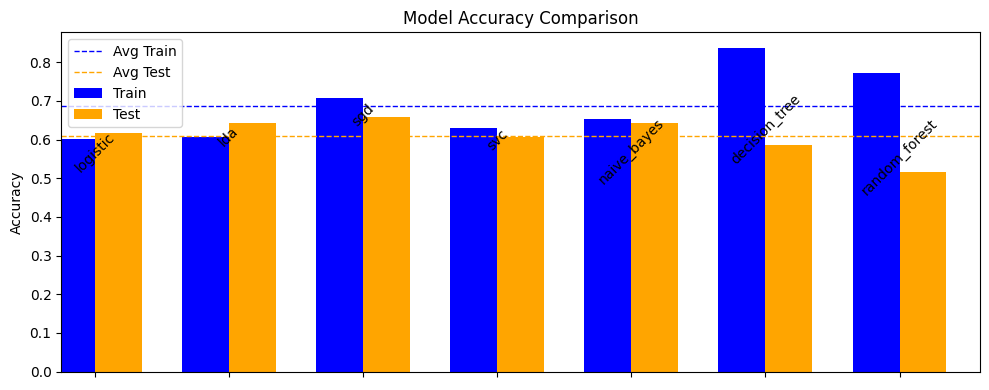

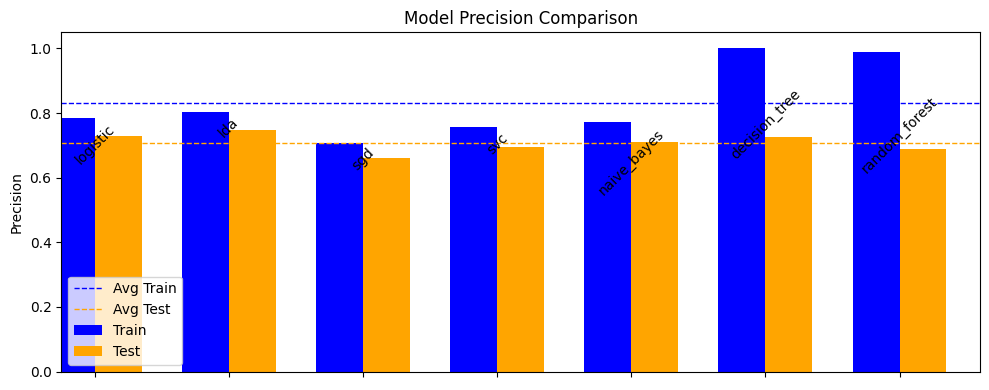

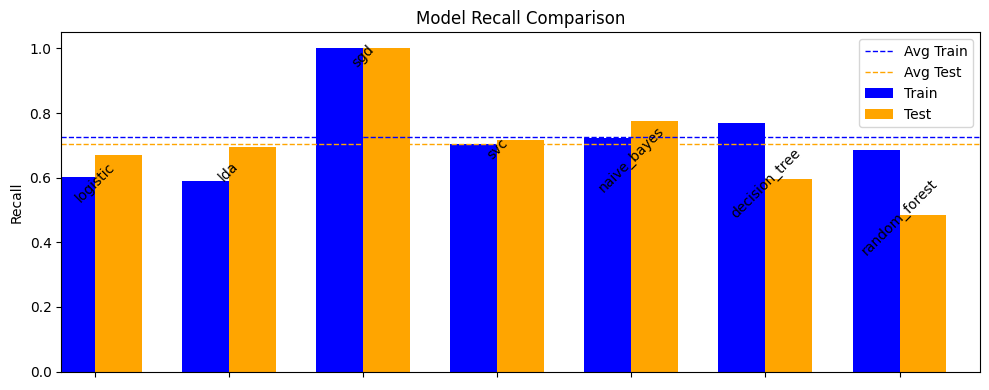

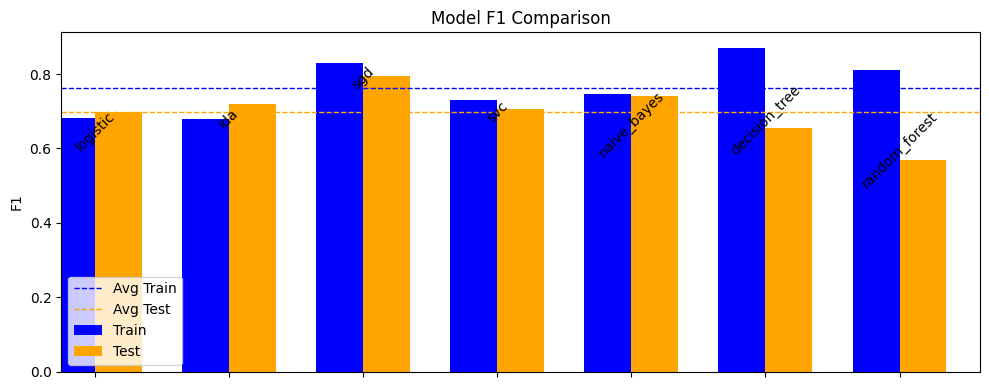

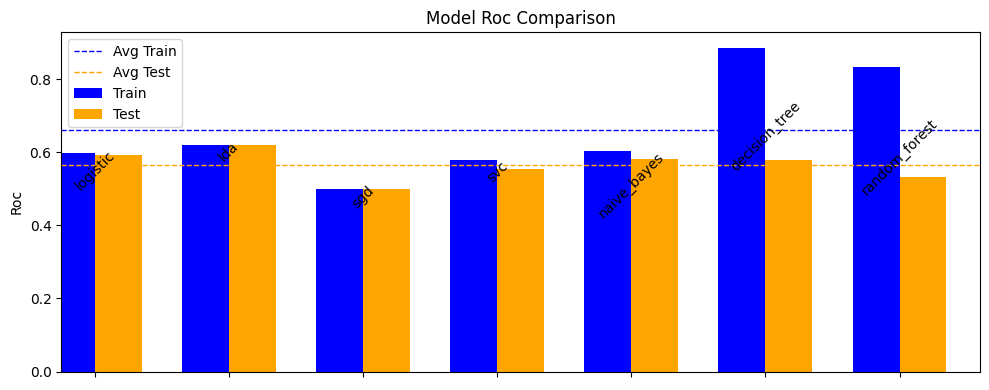

In [14]:
# Convert the result_dict to a DataFrame for easier plotting
metrics = ["accuracy", "precision", "recall", "f1", "roc"]
models = list(result_dict.keys())
data_train = {
    metric: {model: result_dict[model]["train"][metric] for model in models}
    for metric in metrics
}
data_test = {
    metric: {model: result_dict[model]["test"][metric] for model in models}
    for metric in metrics
}

df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)

# Plot the bar chart for each metric
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 4))
    width = 0.35  # the width of the bars

    df_train[metric].plot(
        kind="bar", ax=ax, width=width, position=1, label="Train", color="blue"
    )
    df_test[metric].plot(
        kind="bar", ax=ax, width=width, position=0, label="Test", color="orange"
    )

    # Add horizontal lines for average performance
    avg_train = df_train[metric].mean()
    avg_test = df_test[metric].mean()
    ax.axhline(avg_train, color="blue", linestyle="--", linewidth=1, label="Avg Train")
    ax.axhline(avg_test, color="orange", linestyle="--", linewidth=1, label="Avg Test")

    # Adjust the layout
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f"Model {metric.capitalize()} Comparison")
    ax.legend()

    # Set the x-tick labels inside the bars and rotate by 90 degrees
    ax.set_xticks(range(len(df_train.index)))
    ax.set_xticklabels([])

    # Draw the x-tick labels inside the bars rotated by 90 degrees
    for i, label in enumerate(df_train.index):
        bar_center = (df_train.loc[label, metric] + df_test.loc[label, metric]) / 2
        ax.text(i, bar_center, label, ha="center", va="center_baseline", rotation=45)

    plt.tight_layout()
    plt.show()


In [15]:
# Create a DataFrame combining df_train and df_test
df_combined = pd.concat(
    [df_train.add_suffix("_train"), df_test.add_suffix("_test")], axis=1
)

# Calculate the difference between train and test values
df_combined["accuracy_diff"] = (
    df_combined["accuracy_train"] - df_combined["accuracy_test"]
)
df_combined["precision_diff"] = (
    df_combined["precision_train"] - df_combined["precision_test"]
)
df_combined["recall_diff"] = df_combined["recall_train"] - df_combined["recall_test"]
df_combined["f1_diff"] = df_combined["f1_train"] - df_combined["f1_test"]
df_combined["roc_diff"] = df_combined["roc_train"] - df_combined["roc_test"]

# Detect models with overfitting (significant difference between train and test)
overfitting_threshold = 0.1  # Threshold to consider overfitting
overfitting_models = df_combined[
    (df_combined["accuracy_diff"] > overfitting_threshold)
    | (df_combined["precision_diff"] > overfitting_threshold)
    | (df_combined["recall_diff"] > overfitting_threshold)
    | (df_combined["f1_diff"] > overfitting_threshold)
    | (df_combined["roc_diff"] > overfitting_threshold)
]

# Calculate the average performance in train and test for each metric
mean_performance_train = df_combined[
    ["accuracy_train", "precision_train", "recall_train", "f1_train", "roc_train"]
].mean()
mean_performance_test = df_combined[
    ["accuracy_test", "precision_test", "recall_test", "f1_test", "roc_test"]
].mean()

# Detect models with low performance
# (performance in both train and test below the average of other models)
low_performance_models = df_combined[
    (df_combined["accuracy_train"] < mean_performance_train["accuracy_train"])
    & (df_combined["accuracy_test"] < mean_performance_test["accuracy_test"])
    & (df_combined["precision_train"] < mean_performance_train["precision_train"])
    & (df_combined["precision_test"] < mean_performance_test["precision_test"])
    & (df_combined["recall_train"] < mean_performance_train["recall_train"])
    & (df_combined["recall_test"] < mean_performance_test["recall_test"])
    & (df_combined["f1_train"] < mean_performance_train["f1_train"])
    & (df_combined["f1_test"] < mean_performance_test["f1_test"])
    & (df_combined["roc_train"] < mean_performance_train["roc_train"])
    & (df_combined["roc_test"] < mean_performance_test["roc_test"])
]

print(f"Models with overfitting: {list(overfitting_models.index)} ")
print(f"Models with low performance: {list(low_performance_models.index)} ")

Models with overfitting: ['decision_tree', 'random_forest'] 
Models with low performance: [] 


In [16]:
# Detect models with similar performance in train and test
similar_performance_threshold = 0.05  # Threshold to consider similar performance
similar_performance_models = df_combined[
    (df_combined["accuracy_diff"].abs() < similar_performance_threshold)
    & (df_combined["precision_diff"].abs() < similar_performance_threshold)
    & (df_combined["recall_diff"].abs() < similar_performance_threshold)
    & (df_combined["f1_diff"].abs() < similar_performance_threshold)
    & (df_combined["roc_diff"].abs() < similar_performance_threshold)
]

print(
    "Models with similar performance in train and test: "
    f"{list(similar_performance_models.index)}"
)

Models with similar performance in train and test: ['sgd']


In [17]:
overfitting_models

,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff
decision_tree,0.835561,1.00000,0.767925,0.86873,0.883962,0.585106,0.725490,0.596774,0.654867,0.579637,0.250455,0.274510,0.171150,0.213863,0.304325
random_forest,0.772727,0.98913,0.686792,0.81069,0.834222,0.515957,0.689655,0.483871,0.568720,0.530998,0.256770,0.299475,0.202921,0.241970,0.303224


In [18]:
similar_performance_models

,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff
sgd,0.708556,0.708556,1.0,0.829421,0.5,0.659574,0.659574,1.0,0.794872,0.5,0.048982,0.048982,0.0,0.034549,0.0


Models to discard:
- Naive bayes
- Stochastic gradient descent (sgd)

The models that will be selected to the next step for cross-validation are:
- Logistic regression (simple, good performance and high interpretability)
- Linear discriminant analysis (simple, good performance and high interpretability)
- Decision Tree (simple, good performance and high interpretability, but can be overfitting)
- Random Forest (simple, good performance and high interpretability, but can be overfitting)

SVC and gaussian naive bayes are not selected because they have similar performance than the other models, and svc needs more time to train with more data, naive bayes is a simple model, but theres not range to improve the performance because of the hiperparameters options.

**Cross-validation model selection**

In [19]:
# Define the models to evaluate
models = {
    "logistic": LogisticRegression(solver="liblinear"),
    "lda": LinearDiscriminantAnalysis(),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
}

# Evaluation metrics
scoring_metrics = ["accuracy", "f1", "precision", "recall"]

# StratifiedKFold for the cross-validation
fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

# Variable to store the results of the cross-validation
cv_results = {metric: {} for metric in scoring_metrics}

# Cross-validation evaluation for each model and metric
for model_name, model in models.items():
    model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    for metric in scoring_metrics:
        cv_results[metric][model_name] = cross_val_score(
            model_pipe, x_train, y_train, cv=fold, scoring=metric
        )

# Convert results into a pandas DataFrame for each metric
cv_results_df = {metric: pd.DataFrame(cv_results[metric]) for metric in scoring_metrics}


In [20]:
# Create a DataFrame to store mean and std for each metric and model
mean_std_data = []

for metric_name in scoring_metrics:
    for model_name in models:
        mean_score = cv_results_df[metric_name][model_name].mean()
        std_score = cv_results_df[metric_name][model_name].std()
        mean_std_data.append(
            {
                "Model": model_name,
                "Metric": metric_name,
                "Mean": mean_score,
                "Std": std_score,
            }
        )

mean_std_df = pd.DataFrame(mean_std_data)
mean_std_df

,Model,Metric,Mean,Std
0,logistic,accuracy,0.689892,0.035024
1,lda,accuracy,0.680450,0.037241
2,decision_tree,accuracy,0.628252,0.049074
3,random_forest,accuracy,0.665784,0.050254
4,logistic,f1,0.808848,0.022313
5,lda,f1,0.800102,0.024818
6,decision_tree,f1,0.734764,0.043596
7,random_forest,f1,0.778609,0.031701
8,logistic,precision,0.710711,0.021386
9,lda,precision,0.710752,0.020774


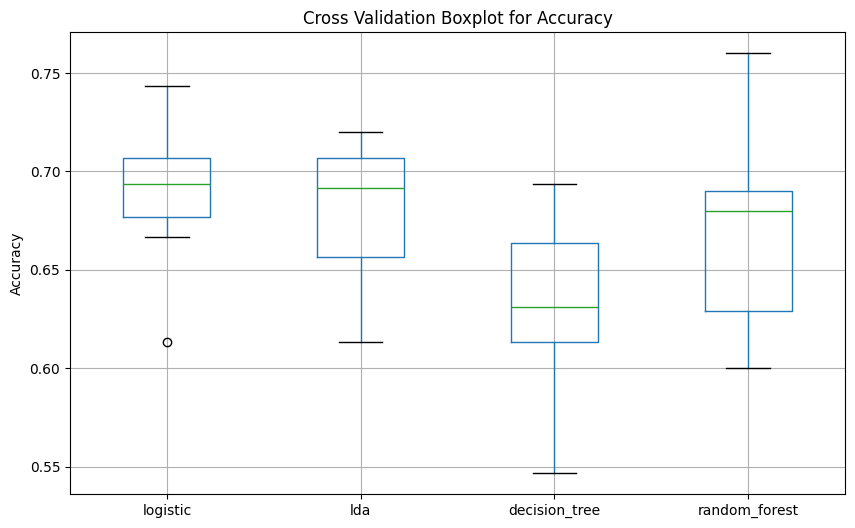

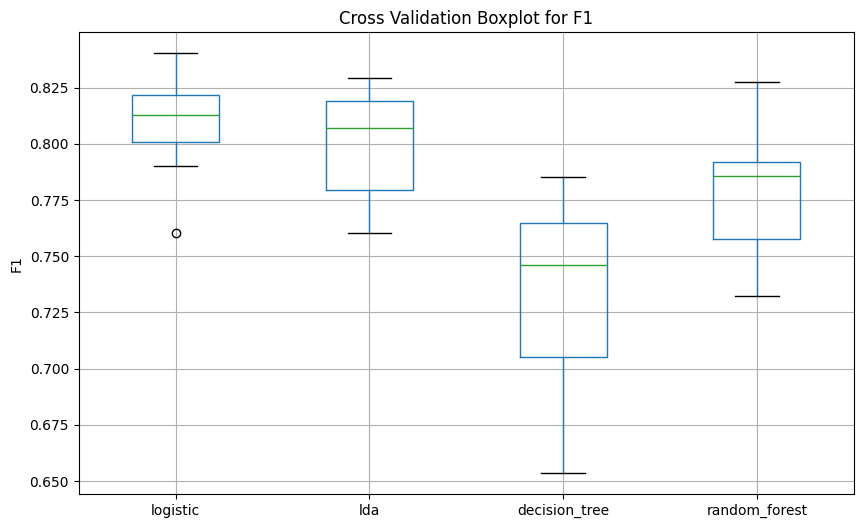

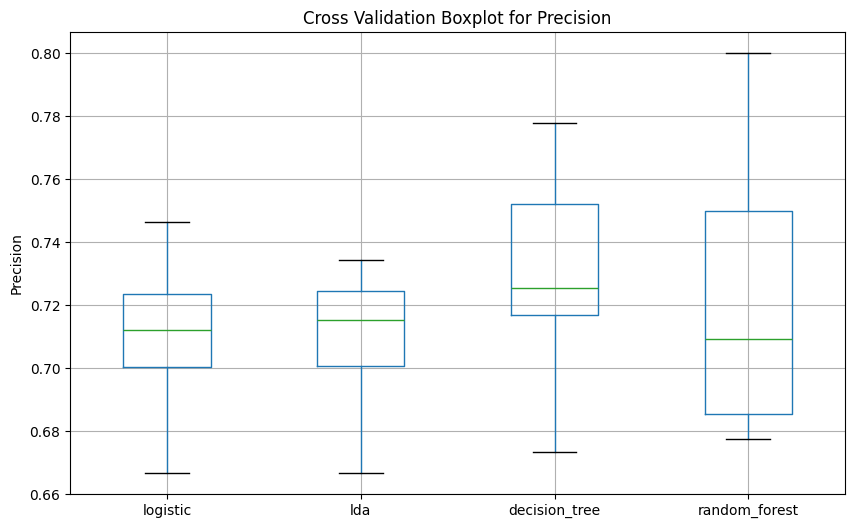

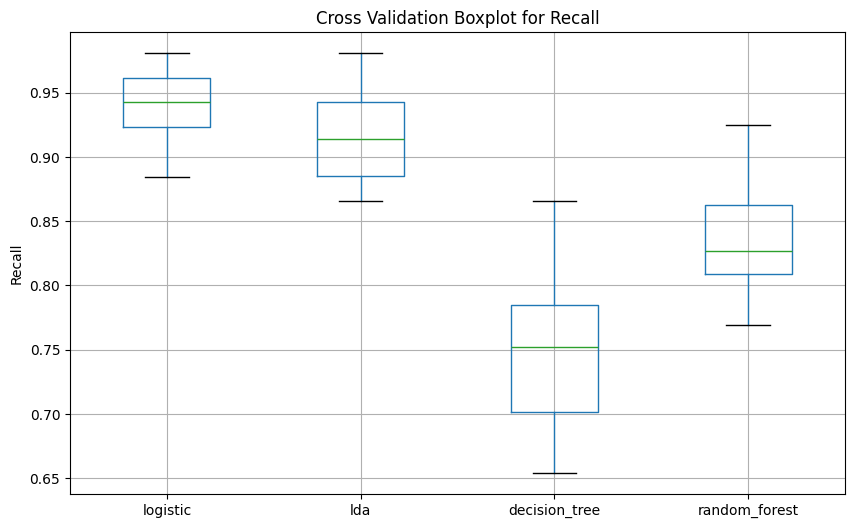

In [21]:
# Create a boxplot for the cross-validation results of each metric
for metric_name in scoring_metrics:
    plt.figure(figsize=(10, 6))
    cv_results_df[metric_name].boxplot()
    plt.title(f"Cross Validation Boxplot for {metric_name.capitalize()}")
    plt.ylabel(f"{metric_name.capitalize()}")
    plt.show()


**Only one metric (Precision)**

Precision is the chosen metric for this credit risk model because it is more important to ensure that approved credits are truly good, minimizing the risk of granting loans to bad creditors.

The objective of this model is to correctly identify good credit applicants while avoiding false approvals of bad credits. Hypothetically, the model is going to be used to approve loans with minimal risk, so precision is the most important metric for this model.

Precision is crucial because it measures the model’s ability to correctly classify applicants as good credit risks. In situations where the cost of approving a bad credit (False Positive, FP) is high—leading to financial losses and increased default rates—it is more important to ensure that approved loans are truly reliable, even if it means rejecting some potentially good applicants.

The False Positive (FP) is the most critical error in this case, as approving a bad credit applicant can result in financial losses. By prioritizing precision, the model ensures that only the most trustworthy applicants are approved, reducing the risk of defaults and improving overall loan portfolio quality.

**Statistical Model Comparison**

In [22]:
result_df = cv_results_df["precision"]
result_df


,logistic,lda,decision_tree,random_forest
0,0.718310,0.724638,0.767857,0.750000
1,0.720588,0.712121,0.700000,0.750000
2,0.724638,0.731343,0.777778,0.800000
3,0.666667,0.666667,0.728814,0.677419
4,0.698630,0.718310,0.725490,0.691176
5,0.724638,0.724638,0.714286,0.683333
6,0.701493,0.703125,0.725490,0.677966
7,0.700000,0.700000,0.760000,0.696970
8,0.705882,0.692308,0.724138,0.721311
9,0.746269,0.734375,0.673469,0.750000


In [23]:
model1 = result_df["logistic"]
model2 = result_df["lda"]
model3 = result_df["decision_tree"]
model4 = result_df["random_forest"]

statistic, p_value = f_oneway(model1, model2, model3, model4)

print(f"Statistic: {statistic}")
print(f"p_value: {p_value}")

alpha = 0.05  # significance level

if p_value < alpha:
    print(
        "There is a statistically significant difference "
        "in the cross-validation results of the models."
    )
else:
    print(
        "There is no statistically significant difference "
        "in the cross-validation results of the models."
    )


Statistic: 0.9118172071522411
p_value: 0.4449236604958363
There is no statistically significant difference in the cross-validation results of the models.


Statistically all the models are similar, so two models are selected to be tuned in the next step:
- Logistic regression (because is simple and has a good performance)
- Random Forest (because its implementation is different than logistic regression, and can be tuned with multiple hyperparameters)

# Hyperparameter tunning

Select the best hyperparameters for the models selected in the previous step.

## Logistic Regression

In [24]:
score = "precision"

parameters = {"model__penalty": ["l1", "l2"], "model__C": [0.1, 0.4, 0.8, 1, 2, 5]}

model = LogisticRegression(solver="liblinear")
logistic_pipe = ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("oversampling", RandomUnderSampler(random_state=42)),
        ("model", model)
    ])

grid_search = GridSearchCV(
    logistic_pipe, parameters, cv=5, scoring=score, return_train_score=True
)
grid_search.fit(x_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('outlier '
                                                                                          'removal',
                                                                                          FunctionTransformer(feature_names_out=<function get_features_names at 0x0000023A1C4DE0C0>,
                                                                                                              func=<function remove_outliers at 0x0000023A1C4DDF80>,
                                                                                                              kw_args={'threshold': 3.0})),
                                                                                         ('imputer',
                                                                                          KNNImputer())]),
                                                                         ['Credit '
                                                                          'amount',...
                                                                                                              func=<function clean_features at 0x0000023A1C4DDC60>)),
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OrdinalEncoder())]),
                                                                         ['Job'])])),
                                       ('oversampling',
                                        RandomUnderSampler(random_state=42)),
                                       ('model',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'model__C': [0.1, 0.4, 0.8, 1, 2, 5],
                         'model__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='precision')

### Evaluation Logistic Regression

In [25]:
logistic_pipe = ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("oversampling", RandomUnderSampler(random_state=42)),
        ("model", LogisticRegression(solver="liblinear"))
    ])

logistic_pipe.set_params(**grid_search.best_params_)

logistic_model = logistic_pipe.fit(x_train, y_train)
y_pred = logistic_model.predict(x_test)

summarize_classification(y_test, y_pred)

{'accuracy': 0.6276595744680851,
 'precision': 0.744,
 'recall': 0.7099236641221374,
 'f1': 0.7265625,
 'roc': 0.5742600776751038}

In [26]:
grid_search.best_params_

{'model__C': 0.1, 'model__penalty': 'l2'}

In [27]:
logistic_pipe.named_steps['model'].get_params()  # just checking if the model got the grid search params right.

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## Random Forest

In [28]:
score = "precision"

parameters = {
    "model__max_depth": [4, 5, 7, 9, 10],
    "model__max_features": [2, 3, 4, 5, 6, 7, 8, 9],
    "model__criterion": ["gini", "entropy"],
}

randomforest_pipe = ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("oversampling", RandomUnderSampler(random_state=42)),
        ("model", RandomForestClassifier())
    ])
grid_search = GridSearchCV(
    randomforest_pipe, parameters, cv=5, scoring=score, return_train_score=True
)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('outlier '
                                                                                          'removal',
                                                                                          FunctionTransformer(feature_names_out=<function get_features_names at 0x0000023A1C4DE0C0>,
                                                                                                              func=<function remove_outliers at 0x0000023A1C4DDF80>,
                                                                                                              kw_args={'threshold': 3.0})),
                                                                                         ('imputer',
                                                                                          KNNImputer())]),
                                                                         ['Credit '
                                                                          'amount',...
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OrdinalEncoder())]),
                                                                         ['Job'])])),
                                       ('oversampling',
                                        RandomUnderSampler(random_state=42)),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [4, 5, 7, 9, 10],
                         'model__max_features': [2, 3, 4, 5, 6, 7, 8, 9]},
             return_train_score=True, scoring='precision')

### Evaluation Random Forest

In [29]:
tree_pipe = ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("oversampling", RandomUnderSampler(random_state=42)),
        ("model", RandomForestClassifier())
    ])

tree_pipe.set_params(**grid_search.best_params_)

tree_model = tree_pipe.fit(x_train, y_train)
y_pred = tree_model.predict(x_test)
summarize_classification(y_test, y_pred)

{'accuracy': 0.6223404255319149,
 'precision': 0.7727272727272727,
 'recall': 0.648854961832061,
 'f1': 0.7053941908713693,
 'roc': 0.6051292353019955}

In [30]:
grid_search.best_params_

{'model__criterion': 'gini', 'model__max_depth': 4, 'model__max_features': 5}

In [31]:
tree_pipe.named_steps['model'].get_params()  # just checking if the model got the grid search params right.

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 5,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# Final evaluation test

## Logistic Regression

In [32]:
y_pred = logistic_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.44      0.42        57
           1       0.74      0.71      0.73       131

    accuracy                           0.63       188
   macro avg       0.57      0.57      0.57       188
weighted avg       0.64      0.63      0.63       188



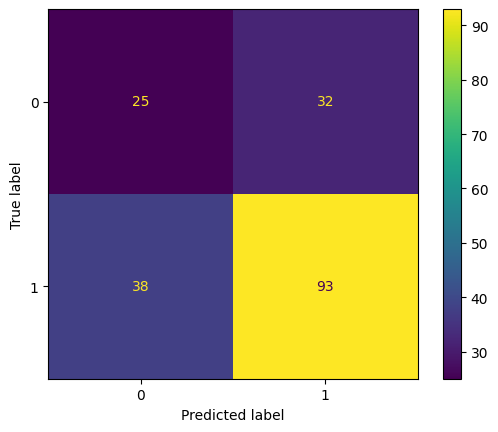

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

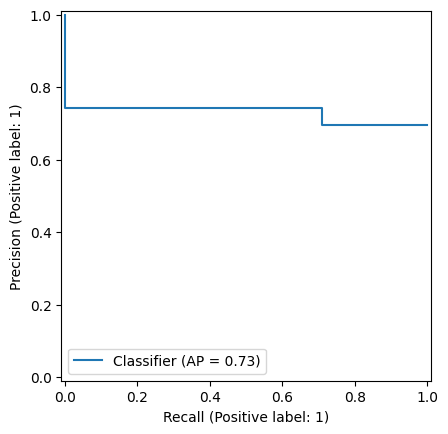

In [34]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)

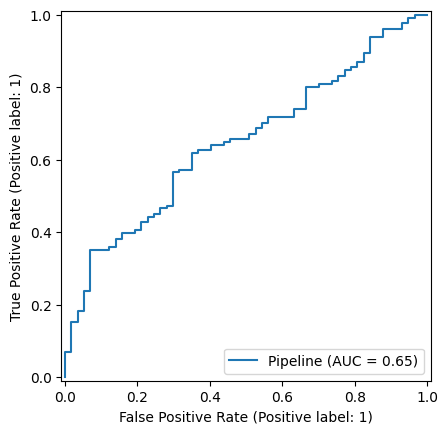

In [35]:
log_plot = RocCurveDisplay.from_estimator(logistic_model, x_test, y_test)
plt.show()

## Random Forest

In [36]:
y_pred = tree_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.56      0.47        57
           1       0.77      0.65      0.71       131

    accuracy                           0.62       188
   macro avg       0.59      0.61      0.59       188
weighted avg       0.66      0.62      0.64       188



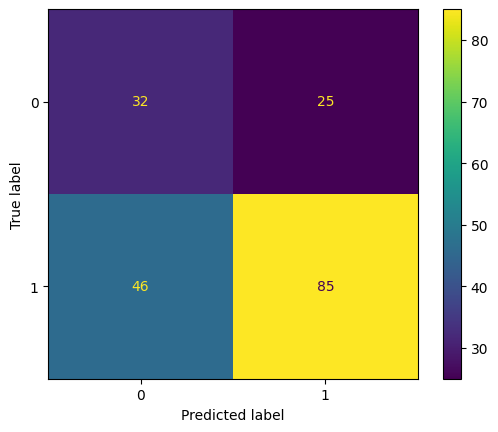

In [37]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

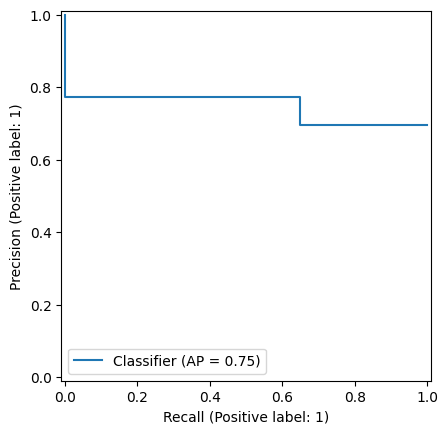

In [38]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)

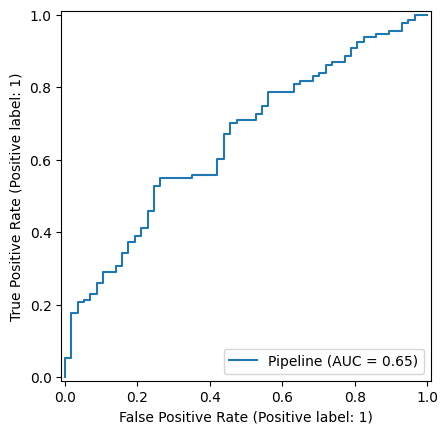

In [39]:
dt_plot = RocCurveDisplay.from_estimator(tree_model, x_test, y_test)
plt.show()

# Model comparison
Logistic regression manages to classify much better the two Risk classes. So Logistic Regression is selected as the best model for this dataset.

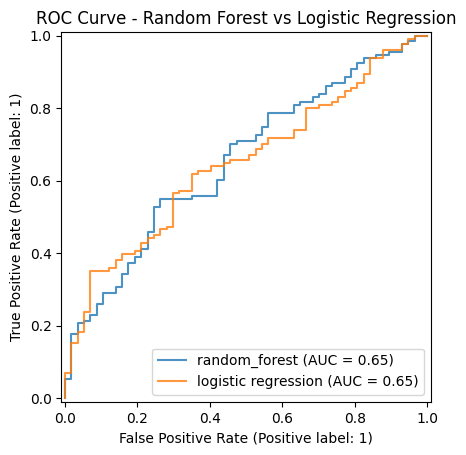

In [40]:
ax = plt.gca()
dt_plot.plot(ax=ax, alpha=0.8, name="random_forest")
log_plot.plot(ax=ax, alpha=0.8, name="logistic regression")
plt.title("ROC Curve - Random Forest vs Logistic Regression")
plt.show()

# Learning curves
This curve is used to see if the models are overfitting or underfitting.

## Logistic regression learning curve

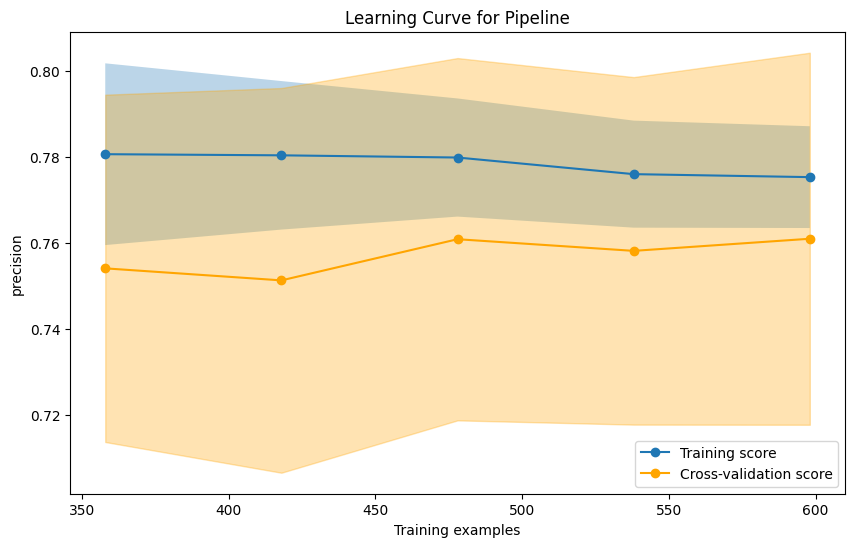

Training Sizes: [358 418 478 538 598]
Training Scores Mean: [0.78054567 0.78028229 0.77977103 0.77590669 0.77521218]
Training Scores Std: [0.02113014 0.01726688 0.01373486 0.01244487 0.0118352 ]
Test Scores Mean: [0.75399973 0.75120436 0.76077588 0.75806701 0.76088571]
Test Scores Std: [0.04037749 0.04472383 0.04211968 0.04040223 0.04325341]


In [41]:
model = logistic_model

# Parameters for the learning curve
common_params = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.6, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
    "n_jobs": -1,
    "return_times": True,
}

scoring_metric = "precision"

# Obtain the learning curve values including fit and score times
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model, **common_params, scoring=scoring_metric
)

# Calculate the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calculate the mean and standard deviation of the fit and score times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plot the learning curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
ax.plot(train_sizes, train_mean, "o-", label="Training score")
ax.plot(train_sizes, test_mean, "o-", color="orange", label="Cross-validation score")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
ax.fill_between(
    train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange"
)

# Configure the title and labels
ax.set_title(f"Learning Curve for {model.__class__.__name__}")
ax.set_xlabel("Training examples")
ax.set_ylabel(scoring_metric)
ax.legend(loc="best")

# Show the plot
plt.show()

# Print the values for analysis
print("Training Sizes:", train_sizes)
print("Training Scores Mean:", train_mean)
print("Training Scores Std:", train_std)
print("Test Scores Mean:", test_mean)
print("Test Scores Std:", test_std)


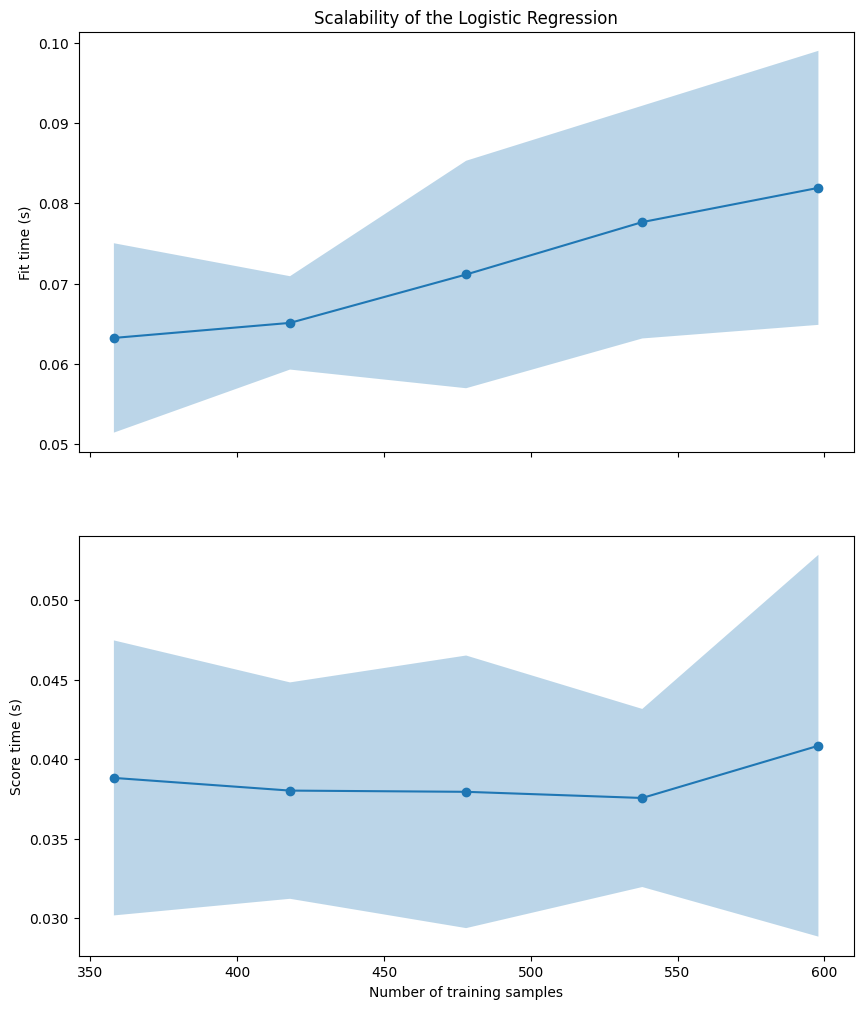

Fit Times Mean: [0.06323328 0.06510593 0.07113156 0.077655   0.0819188 ]
Fit Times Std: [0.01178945 0.00581145 0.01415978 0.01448782 0.01705854]
Score Times Mean: [0.03881485 0.03801751 0.03794062 0.03755346 0.0408385 ]
Score Times Std: [0.00864549 0.00680307 0.00856911 0.00559853 0.01200252]


In [42]:
# Plot the scalability regarding fit time and score time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Scalability regarding the fit time
ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title("Scalability of the Logistic Regression")

# Scalability regarding the score time
ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

# Show the plot
plt.show()

# Print the fit and score times for analysis
print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)


## Random Forest learning curve

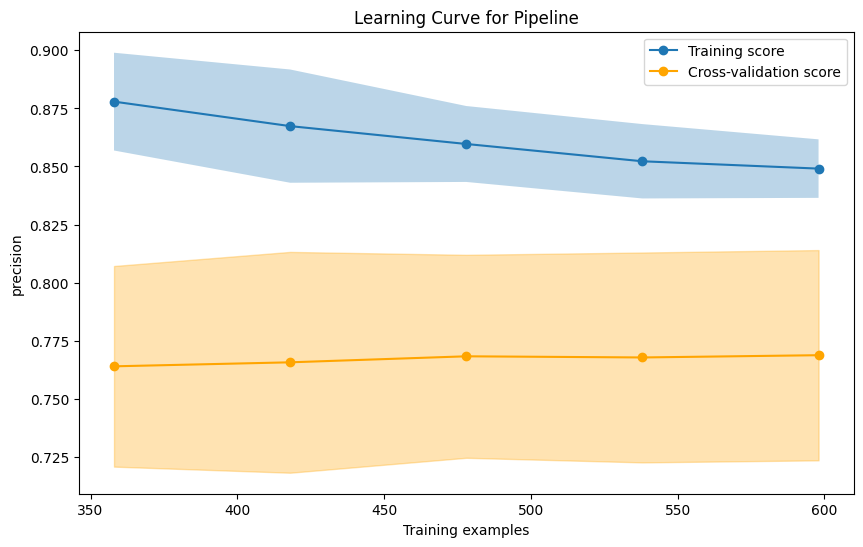

Training Sizes: [358 418 478 538 598]
Training Scores Mean: [0.87793186 0.86737765 0.85968405 0.85223514 0.84907653]
Training Scores Std: [0.02105891 0.02439186 0.01635215 0.01601554 0.01260128]
Test Scores Mean: [0.76391631 0.76563965 0.76823124 0.76773334 0.76870428]
Test Scores Std: [0.04320555 0.04755319 0.04370958 0.04519918 0.04528421]


In [43]:
model = tree_model

# Parameters for the learning curve
common_params = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.6, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
    "n_jobs": -1,
    "return_times": True,
}

scoring_metric = "precision"

# Obtain the learning curve values including fit and score times
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model, **common_params, scoring=scoring_metric
)

# Calculate the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calculate the mean and standard deviation of the fit and score times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plot the learning curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
ax.plot(train_sizes, train_mean, "o-", label="Training score")
ax.plot(train_sizes, test_mean, "o-", color="orange", label="Cross-validation score")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
ax.fill_between(
    train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange"
)

# Configure the title and labels
ax.set_title(f"Learning Curve for {model.__class__.__name__}")
ax.set_xlabel("Training examples")
ax.set_ylabel(scoring_metric)
ax.legend(loc="best")

# Show the plot
plt.show()

# Print the values for analysis
print("Training Sizes:", train_sizes)
print("Training Scores Mean:", train_mean)
print("Training Scores Std:", train_std)
print("Test Scores Mean:", test_mean)
print("Test Scores Std:", test_std)

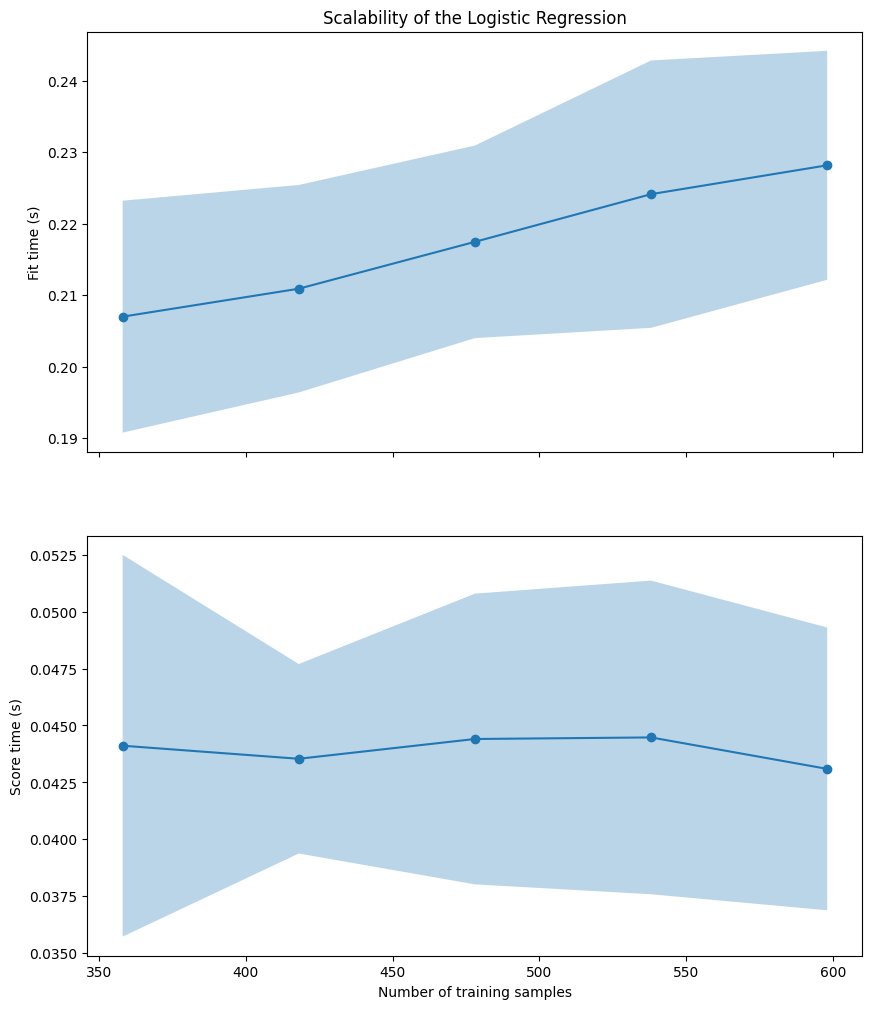

Fit Times Mean: [0.2070146  0.21092069 0.21747507 0.22413866 0.22817307]
Fit Times Std: [0.01621201 0.0145054  0.01345976 0.01869015 0.01600458]
Score Times Mean: [0.0441108  0.04353751 0.04440626 0.04447535 0.04309367]
Score Times Std: [0.00838639 0.00416197 0.00638587 0.00688982 0.00621217]


In [44]:
# Plot the scalability regarding fit time and score time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Scalability regarding the fit time
ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title("Scalability of the Logistic Regression")

# Scalability regarding the score time
ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

# Show the plot
plt.show()

# Print the fit and score times for analysis
print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)

**Analysis of results**

Finally, let's **save** and **test** the model

In [48]:
dump(logistic_model, r"../models/credit_classification-logistic_regression-v1.joblib")  # save

['../models/credit_classification-logistic_regression-v1.joblib']

In [50]:
my_model: LogisticRegression = load(r"../models/credit_classification-logistic_regression-v1.joblib")

In [51]:
x_test.head()

,Credit amount,Purpose,Job,Sex,Saving accounts,Housing,Age
248,10961,6,2.0,male,rich,own,27
1529,2331,radio/TV,2.0,male,NaN,own,49
960,1503,radio/TV,1.0,male,little,own,42
985,2762,furniture/equipment,2.0,female,NaN,own,25
452,2133,car,3.0,female,NaN,free,52


In [52]:
my_model.predict(x_test.head())

array([1, 1, 1, 0, 1], dtype=int64)